# TOI 3-Class Machine Learning Model Training v2
## Exoplanet Classification: Confirmed Planet vs Planet Candidate vs False Positive

This notebook implements state-of-the-art machine learning models for 3-class exoplanet classification using the preprocessed TOI (TESS Objects of Interest) dataset.

### Target Classes:
- **Confirmed_Planet** (CP + KP): Confirmed exoplanets
- **Planet_Candidate** (PC + APC): Potential exoplanets needing follow-up
- **False_Positive** (FP + FA): Non-planetary signals

### Model Pipeline:
1. **Data Loading** - Load preprocessed 3-class features

2. **Model Selection** - RandomForest, XGBoost, LightGBM6. **Production Deployment** - Model Serialization

3. **Hyperparameter Tuning** - GridSearch optimized for multiclass5. **Advanced Evaluation** - Multiclass metrics, ROC curves, SHAP Analysis
4. **Ensemble Methods** - Voting & Stacking Classifiers

In [1]:
# 1. IMPORT LIBRARIES AND DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# SHAP for model interpretation
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False
    print("SHAP not available. Install with: pip install shap")

print("✅ All libraries imported successfully!")
print(f"🔍 SHAP interpretation: {'Available' if shap_available else 'Not Available'}")

SHAP not available. Install with: pip install shap
✅ All libraries imported successfully!
🔍 SHAP interpretation: Not Available


In [2]:
# 2. LOAD PREPROCESSED 3-CLASS DATA FROM VOL2
print("📂 Loading 3-class data from vol2/...")

# Load preprocessed 3-class data
X_train_scaled = pd.read_csv('vol2/X_train_scaled.csv')
X_test_scaled = pd.read_csv('vol2/X_test_scaled.csv') 
y_train = pd.read_csv('vol2/y_train.csv')['target']
y_test = pd.read_csv('vol2/y_test.csv')['target']

# Load class mapping for interpretation
import json
with open('vol2/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)

# Get feature names from columns
feature_names = list(X_train_scaled.columns)


print("✅ 3-Class data loaded successfully!")
print(f"🚀 Ready for 3-class model training!")

print(f"📊 Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"📉 Test Distribution: {dict(y_test.value_counts())}")

print(f"🎯 Target Classes: {class_mapping['class_names']}")
print(f"📈 Train Distribution: {dict(y_train.value_counts())}")
print(f"🔄 Class Grouping: {class_mapping['class_grouping']}")

📂 Loading 3-class data from vol2/...
✅ 3-Class data loaded successfully!
🚀 Ready for 3-class model training!
📊 Training: (6162, 76), Test: (1541, 76)
📉 Test Distribution: {'Planet_Candidate': 1029, 'False_Positive': 259, 'Confirmed_Planet': 253}
🎯 Target Classes: ['Confirmed_Planet', 'False_Positive', 'Planet_Candidate']
📈 Train Distribution: {'Planet_Candidate': 4112, 'False_Positive': 1036, 'Confirmed_Planet': 1014}
🔄 Class Grouping: {'Confirmed_Planet': ['CP', 'KP'], 'Planet_Candidate': ['PC', 'APC'], 'False_Positive': ['FP', 'FA']}


In [3]:
# 3. MODEL DEFINITIONS AND HYPERPARAMETER SPACES

# Model configurations for hyperparameter tuning
model_configs = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2]
        }
    },
    
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbosity=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [31, 50, 100],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [0, 0.1, 1]
        }
    }
}

print("🚀 Model configurations ready for hyperparameter tuning!")
print(f"📋 Available models: {list(model_configs.keys())}")

🚀 Model configurations ready for hyperparameter tuning!
📋 Available models: ['RandomForest', 'XGBoost', 'LightGBM']


In [4]:
# 4. ADVANCED MODEL TRAINING FUNCTION

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name, model, param_grid, cv=3):
    """
    Advanced 3-class model training with hyperparameter optimization
    """
    print(f"\n🔧 Training {model_name} for 3-class classification...")
    
    # Grid Search with cross-validation optimized for multiclass
    grid_search = RandomizedSearchCV(
        model, param_grid, 
        cv=cv, 
        scoring='f1_macro',  # Optimized for multiclass imbalanced data
        n_iter=20,  # Reduced for faster training
        n_jobs=-1, 
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Multiclass metrics
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Results dictionary
    results = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred)
    }
    

    print(f"✅ {model_name} training completed!")
    print("🛠️ Advanced training function ready!")

    print(f"🎯 Best CV F1-Macro: {grid_search.best_score_:.4f}")

    print(f"📊 Test F1-Macro: {f1_macro:.4f}")    

    print(f"📊 Test F1-Weighted: {f1_weighted:.4f}")    
    print(f"📊 Test Accuracy: {accuracy:.4f}")
    return results

In [5]:
# 5. TRAIN ALL MODELS
# Bu hücre tüm modelleri eğitir ve sonuçları karşılaştırır

# Results storage
all_results = {}

# Train each model
if 'X_train_scaled' in locals():
    for model_name, config in model_configs.items():
        try:
            results = train_and_evaluate_model(
                X_train_scaled, X_test_scaled, y_train, y_test,
                model_name, config['model'], config['params']
            )
            all_results[model_name] = results
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")
            continue
    
    print(f"\n🏆 Training completed for {len(all_results)} models!")    
    
    # Model comparison for 3-class
    print("\n📊 3-CLASS MODEL COMPARISON:")
    print("-" * 70)
    comparison_df = pd.DataFrame({
        model_name: {
            'CV_F1_Macro': results.get('cv_score', 0),
            'Test_F1_Macro': results.get('f1_macro', 0),
            'Test_F1_Weighted': results.get('f1_weighted', 0),
            'Test_Accuracy': results.get('accuracy', 0)
        }
        for model_name, results in all_results.items()
    }).T
    
    comparison_df = comparison_df.round(4)
    print(comparison_df)
    
    # Best model selection based on F1-Macro (better for multiclass imbalanced)
    best_model_name = comparison_df['Test_F1_Macro'].idxmax()
    print(f"\n🥇 Best model (by F1-Macro): {best_model_name}")
    print(f"🎯 Best F1-Macro score: {comparison_df.loc[best_model_name, 'Test_F1_Macro']:.4f}")
    print(f"🎯 Best F1-Weighted score: {comparison_df.loc[best_model_name, 'Test_F1_Weighted']:.4f}")
    print(f"🎯 Best Accuracy: {comparison_df.loc[best_model_name, 'Test_Accuracy']:.4f}")

else:    print("⚠️ Data not loaded. Please run the data loading cell first.")


🔧 Training RandomForest for 3-class classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ RandomForest training completed!
🛠️ Advanced training function ready!
🎯 Best CV F1-Macro: 0.8627
📊 Test F1-Macro: 0.8564
📊 Test F1-Weighted: 0.8927
📊 Test Accuracy: 0.8994

🔧 Training XGBoost for 3-class classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ RandomForest training completed!
🛠️ Advanced training function ready!
🎯 Best CV F1-Macro: 0.8627
📊 Test F1-Macro: 0.8564
📊 Test F1-Weighted: 0.8927
📊 Test Accuracy: 0.8994

🔧 Training XGBoost for 3-class classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
❌ Error training XGBoost: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the

In [6]:
# 6. ENSEMBLE METHODS FOR 3-CLASS CLASSIFICATION

if len(all_results) >= 2:
    print("🎪 Creating 3-Class Ensemble Models...")
    
    # Get top models (only those that trained successfully)
    valid_models = {}
    for name, results in all_results.items():
        if 'model' in results and hasattr(results['model'], 'predict_proba'):
            valid_models[name] = results
    
    print(f"📊 Valid models for ensemble: {list(valid_models.keys())}")
    
    if len(valid_models) >= 2:
        # Create comparison dataframe for valid models
        comparison_df = pd.DataFrame({
            model_name: {
                'CV_F1_Macro': results.get('cv_score', 0),
                'Test_F1_Macro': results.get('f1_macro', 0),
                'Test_F1_Weighted': results.get('f1_weighted', 0),
                'Test_Accuracy': results.get('accuracy', 0)
            }
            for model_name, results in valid_models.items()
        }).T
        
        # Get top 3 models based on F1-Macro
        top_models = comparison_df.nlargest(min(3, len(valid_models)), 'Test_F1_Macro')
        print(f"🥇 Top models for ensemble: {list(top_models.index)}")
        
        # Prepare base models for ensemble
        base_models = [
            (name, valid_models[name]['model']) 
            for name in top_models.index
        ]
        
        try:
            # 1. Voting Classifier (Soft voting) for 3-class
            voting_clf = VotingClassifier(
                estimators=base_models, 
                voting='soft'
            )
            
            print("🗳️ Training 3-Class Voting Classifier...")
            voting_clf.fit(X_train_scaled, y_train)
            
            # Evaluate Voting Classifier for multiclass
            voting_pred = voting_clf.predict(X_test_scaled)
            voting_pred_proba = voting_clf.predict_proba(X_test_scaled)
            
            from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
            voting_f1_macro = f1_score(y_test, voting_pred, average='macro')
            voting_f1_weighted = f1_score(y_test, voting_pred, average='weighted')
            voting_accuracy = accuracy_score(y_test, voting_pred)
            
            print(f"✅ Voting Classifier - F1-Macro: {voting_f1_macro:.4f}, F1-Weighted: {voting_f1_weighted:.4f}, Accuracy: {voting_accuracy:.4f}")
            
            # Add voting results
            all_results['VotingClassifier'] = {
                'model': voting_clf,
                'f1_macro': voting_f1_macro,
                'f1_weighted': voting_f1_weighted,
                'accuracy': voting_accuracy,
                'y_pred': voting_pred,
                'y_pred_proba': voting_pred_proba
            }
            
        except Exception as e:
            print(f"❌ Voting Classifier failed: {e}")
        
        try:
            # 2. Stacking Classifier for 3-class
            stacking_clf = StackingClassifier(
                estimators=base_models,
                final_estimator=LogisticRegression(random_state=42, max_iter=1000),
                cv=3
            )
            
            print("🏗️ Training 3-Class Stacking Classifier...")
            stacking_clf.fit(X_train_scaled, y_train)
            
            # Evaluate Stacking Classifier for multiclass
            stacking_pred = stacking_clf.predict(X_test_scaled)
            stacking_pred_proba = stacking_clf.predict_proba(X_test_scaled)
            
            stacking_f1_macro = f1_score(y_test, stacking_pred, average='macro')
            stacking_f1_weighted = f1_score(y_test, stacking_pred, average='weighted')
            stacking_accuracy = accuracy_score(y_test, stacking_pred)
            
            print(f"✅ Stacking Classifier - F1-Macro: {stacking_f1_macro:.4f}, F1-Weighted: {stacking_f1_weighted:.4f}, Accuracy: {stacking_accuracy:.4f}")
            
            # Add stacking results
            all_results['StackingClassifier'] = {
                'model': stacking_clf,
                'f1_macro': stacking_f1_macro,
                'f1_weighted': stacking_f1_weighted,
                'accuracy': stacking_accuracy,
                'y_pred': stacking_pred,
                'y_pred_proba': stacking_pred_proba
            }
            
        except Exception as e:
            print(f"❌ Stacking Classifier failed: {e}")
        
        print("🎭 Ensemble methods completed!")
        
    else:
        print(f"⚠️ Need at least 2 valid models for ensemble methods (found {len(valid_models)})")
        
else:
    print("⚠️ Need at least 2 models for ensemble methods")

🎪 Creating 3-Class Ensemble Models...
📊 Valid models for ensemble: ['RandomForest', 'LightGBM']
🥇 Top models for ensemble: ['LightGBM', 'RandomForest']
🗳️ Training 3-Class Voting Classifier...
✅ Voting Classifier - F1-Macro: 0.8865, F1-Weighted: 0.9138, Accuracy: 0.9176
🏗️ Training 3-Class Stacking Classifier...
✅ Voting Classifier - F1-Macro: 0.8865, F1-Weighted: 0.9138, Accuracy: 0.9176
🏗️ Training 3-Class Stacking Classifier...
✅ Stacking Classifier - F1-Macro: 0.8858, F1-Weighted: 0.9132, Accuracy: 0.9169
🎭 Ensemble methods completed!
✅ Stacking Classifier - F1-Macro: 0.8858, F1-Weighted: 0.9132, Accuracy: 0.9169
🎭 Ensemble methods completed!


In [7]:
# 5.1 CHECK TRAINED MODELS STATUS
print("🔍 Checking trained models status...")

if 'all_results' in locals() and len(all_results) > 0:
    print(f"📊 Found {len(all_results)} trained models:")
    for name, results in all_results.items():
        if 'model' in results:
            model = results['model']
            has_predict_proba = hasattr(model, 'predict_proba')
            print(f"  ✓ {name}: {type(model).__name__} - predict_proba: {has_predict_proba}")
            if 'f1_macro' in results:
                print(f"    F1-Macro: {results['f1_macro']:.4f}, F1-Weighted: {results['f1_weighted']:.4f}, Accuracy: {results['accuracy']:.4f}")
        else:
            print(f"  ❌ {name}: No model found")
else:
    print("❌ No models found in all_results!")
    print("📝 Please run cell 5 (TRAIN ALL MODELS) first")
    print("\n🔄 Running simple 3-class model training for testing...")
    
    # Quick RandomForest for 3-class testing
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score, accuracy_score
    rf_test = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_test.fit(X_train_scaled, y_train)
    y_pred_test = rf_test.predict(X_test_scaled)
    y_pred_proba_test = rf_test.predict_proba(X_test_scaled)
    
    f1_macro_test = f1_score(y_test, y_pred_test, average='macro')
    f1_weighted_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    all_results = {
        'RandomForest_Test': {
            'model': rf_test,
            'f1_macro': f1_macro_test,
            'f1_weighted': f1_weighted_test,
            'accuracy': accuracy_test,
            'y_pred': y_pred_test,
            'y_pred_proba': y_pred_proba_test
        }
    }
    
    print(f"✅ Test 3-class model trained - F1-Macro: {f1_macro_test:.4f}, Accuracy: {accuracy_test:.4f}")

print("\n" + "="*50)

🔍 Checking trained models status...
📊 Found 4 trained models:
  ✓ RandomForest: RandomForestClassifier - predict_proba: True
    F1-Macro: 0.8564, F1-Weighted: 0.8927, Accuracy: 0.8994
  ✓ LightGBM: LGBMClassifier - predict_proba: True
    F1-Macro: 0.8912, F1-Weighted: 0.9173, Accuracy: 0.9208
  ✓ VotingClassifier: VotingClassifier - predict_proba: True
    F1-Macro: 0.8865, F1-Weighted: 0.9138, Accuracy: 0.9176
  ✓ StackingClassifier: StackingClassifier - predict_proba: True
    F1-Macro: 0.8858, F1-Weighted: 0.9132, Accuracy: 0.9169



🎨 Creating 3-Class evaluation visualizations...


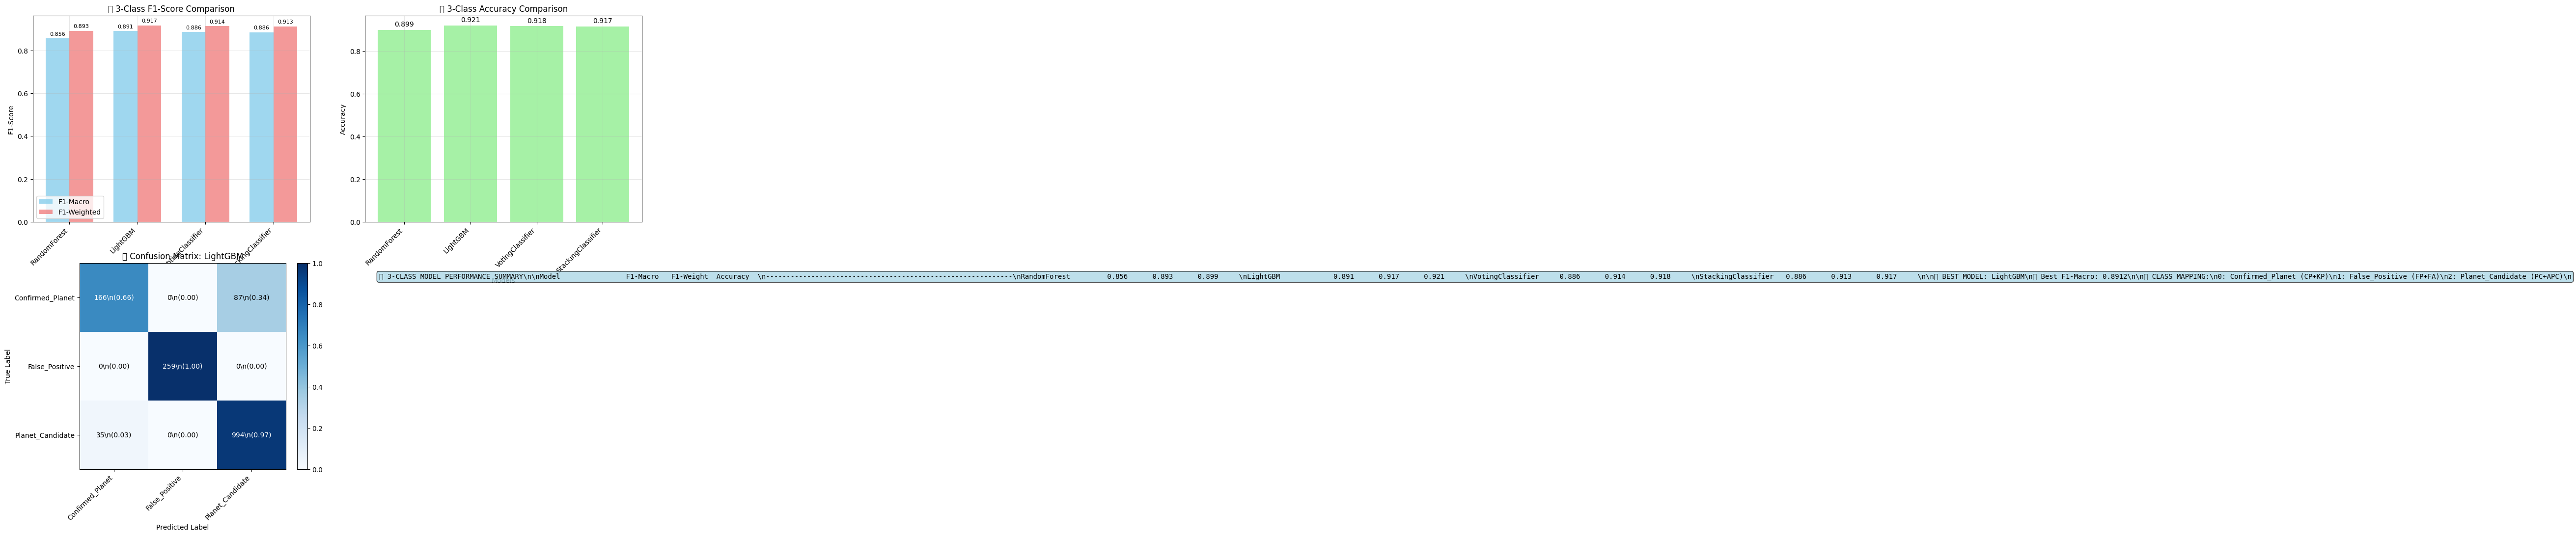

\n📈 DETAILED 3-CLASS RESULTS:
\n🔸 RandomForest:
  F1-Macro: 0.8564
  F1-Weighted: 0.8927
  Accuracy: 0.8994
  Classification Report:
                  precision    recall  f1-score   support

Confirmed_Planet       0.77      0.55      0.64       253
  False_Positive       1.00      1.00      1.00       259
Planet_Candidate       0.90      0.96      0.93      1029

        accuracy                           0.90      1541
       macro avg       0.89      0.84      0.86      1541
    weighted avg       0.89      0.90      0.89      1541

\n🔸 LightGBM:
  F1-Macro: 0.8912
  F1-Weighted: 0.9173
  Accuracy: 0.9208
  Classification Report:
                  precision    recall  f1-score   support

Confirmed_Planet       0.83      0.66      0.73       253
  False_Positive       1.00      1.00      1.00       259
Planet_Candidate       0.92      0.97      0.94      1029

        accuracy                           0.92      1541
       macro avg       0.92      0.87      0.89      1541
    weigh

In [8]:
# 7. COMPREHENSIVE 3-CLASS VISUALIZATION & EVALUATION

def plot_3class_evaluation(results_dict, y_true, class_names):
    """
    Create comprehensive evaluation plots for 3-class models
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. F1-Score Comparison
    ax1 = axes[0, 0]
    model_names = list(results_dict.keys())
    f1_macro_scores = [results_dict[name].get('f1_macro', 0) for name in model_names]
    f1_weighted_scores = [results_dict[name].get('f1_weighted', 0) for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, f1_macro_scores, width, label='F1-Macro', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, f1_weighted_scores, width, label='F1-Weighted', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('F1-Score')
    ax1.set_title('🎯 3-Class F1-Score Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # 2. Accuracy Comparison
    ax2 = axes[0, 1]
    accuracy_scores = [results_dict[name].get('accuracy', 0) for name in model_names]
    
    bars = ax2.bar(model_names, accuracy_scores, alpha=0.8, color='lightgreen')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('📊 3-Class Accuracy Comparison')
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # 3. Confusion Matrix for Best Model
    ax3 = axes[1, 0]
    if len(results_dict) > 0:
        # Find best model by F1-Macro
        best_model_name = max(model_names, key=lambda x: results_dict[x].get('f1_macro', 0))
        best_results = results_dict[best_model_name]
        
        if 'y_pred' in best_results:
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_true, best_results['y_pred'])
            
            # Normalize confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            im = ax3.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
            ax3.set_title(f'🎯 Confusion Matrix: {best_model_name}')
            
            # Add text annotations
            thresh = cm_normalized.max() / 2
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax3.text(j, i, f'{cm[i, j]}\\n({cm_normalized[i, j]:.2f})',
                            ha="center", va="center",
                            color="white" if cm_normalized[i, j] > thresh else "black")
            
            ax3.set_xlabel('Predicted Label')
            ax3.set_ylabel('True Label')
            ax3.set_xticks(range(len(class_names)))
            ax3.set_yticks(range(len(class_names)))
            ax3.set_xticklabels(class_names, rotation=45, ha='right')
            ax3.set_yticklabels(class_names)
            
            # Add colorbar
            plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    
    # 4. Performance Metrics Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary table
    summary_text = "🏆 3-CLASS MODEL PERFORMANCE SUMMARY\\n\\n"
    summary_text += f"{'Model':<20} {'F1-Macro':<10} {'F1-Weight':<10} {'Accuracy':<10}\\n"
    summary_text += "-" * 60 + "\\n"
    
    for name in model_names:
        f1_macro = results_dict[name].get('f1_macro', 0)
        f1_weighted = results_dict[name].get('f1_weighted', 0)
        accuracy = results_dict[name].get('accuracy', 0)
        summary_text += f"{name:<20} {f1_macro:<10.3f} {f1_weighted:<10.3f} {accuracy:<10.3f}\\n"
    
    # Best model highlight
    if len(results_dict) > 0:
        best_model = max(model_names, key=lambda x: results_dict[x].get('f1_macro', 0))
        best_f1 = results_dict[best_model].get('f1_macro', 0)
        summary_text += f"\\n🥇 BEST MODEL: {best_model}\\n"
        summary_text += f"🎯 Best F1-Macro: {best_f1:.4f}\\n"
        summary_text += f"\\n📋 CLASS MAPPING:\\n"
        summary_text += f"0: Confirmed_Planet (CP+KP)\\n"
        summary_text += f"1: False_Positive (FP+FA)\\n"
        summary_text += f"2: Planet_Candidate (PC+APC)\\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Execute visualization
if 'all_results' in locals() and len(all_results) > 0:
    print("🎨 Creating 3-Class evaluation visualizations...")
    
    # Get class names from mapping
    if 'class_mapping' in locals():
        class_names = class_mapping['class_names']
    else:
        class_names = ['Confirmed_Planet', 'False_Positive', 'Planet_Candidate']
    
    plot_3class_evaluation(all_results, y_test, class_names)
    
    # Print detailed results
    print("\\n📈 DETAILED 3-CLASS RESULTS:")
    print("=" * 70)
    for name, results in all_results.items():
        print(f"\\n🔸 {name}:")
        if 'f1_macro' in results:
            print(f"  F1-Macro: {results['f1_macro']:.4f}")
            print(f"  F1-Weighted: {results['f1_weighted']:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
        
        if 'classification_report' in results:
            print("  Classification Report:")
            print(results['classification_report'])
            
else:
    print("⚠️ No models available for visualization!")
    
# The 3-class evaluation plots are already created in cell 7
# This section is handled by the plot_3class_evaluation function above
print("✅ 3-Class evaluation plots completed in previous cell!")

🎨 TÜM GRAFİKLERİ AYRI AYRI OLUŞTURULUYOR...
📊 1. F1-SCORE KARŞILAŞTIRMASI
--------------------------------------------------


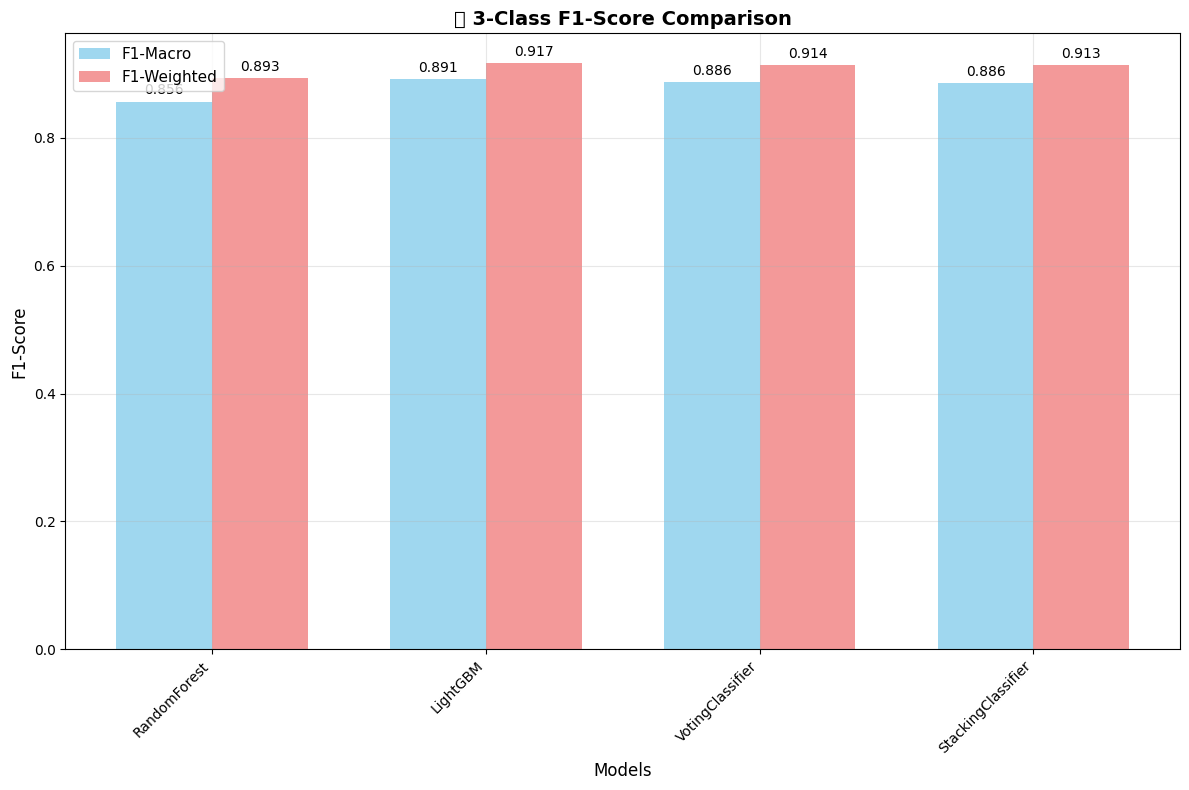


📈 2. ACCURACY KARŞILAŞTIRMASI
--------------------------------------------------


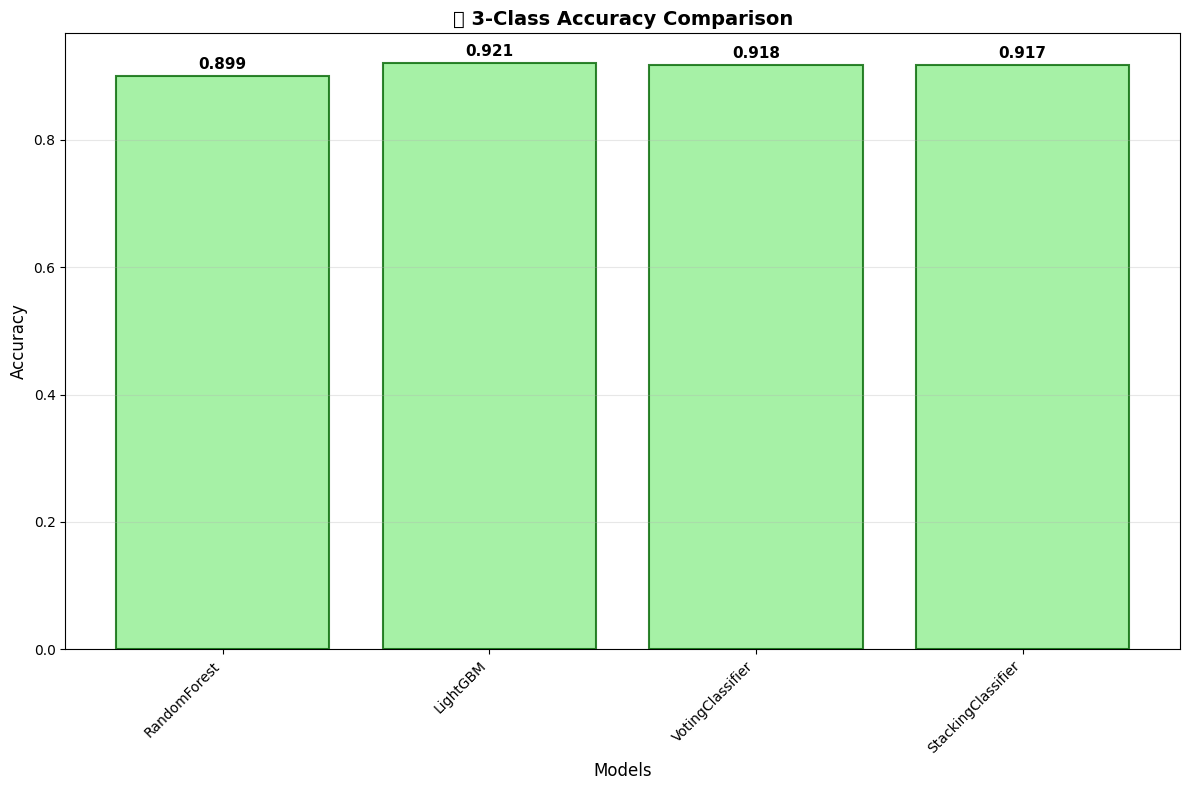


🎯 3. CONFUSION MATRIX (EN İYİ MODEL)
--------------------------------------------------
En iyi model: LightGBM
F1-Macro: 0.8912


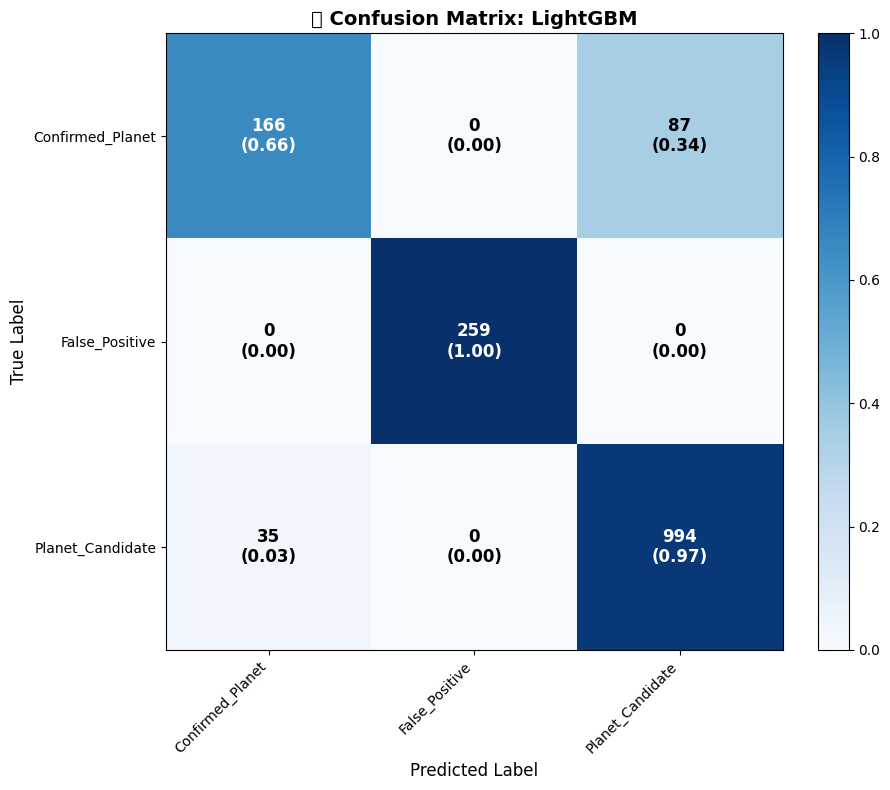


🏆 4. PERFORMANS METRİKLERİ TABLOSU
--------------------------------------------------


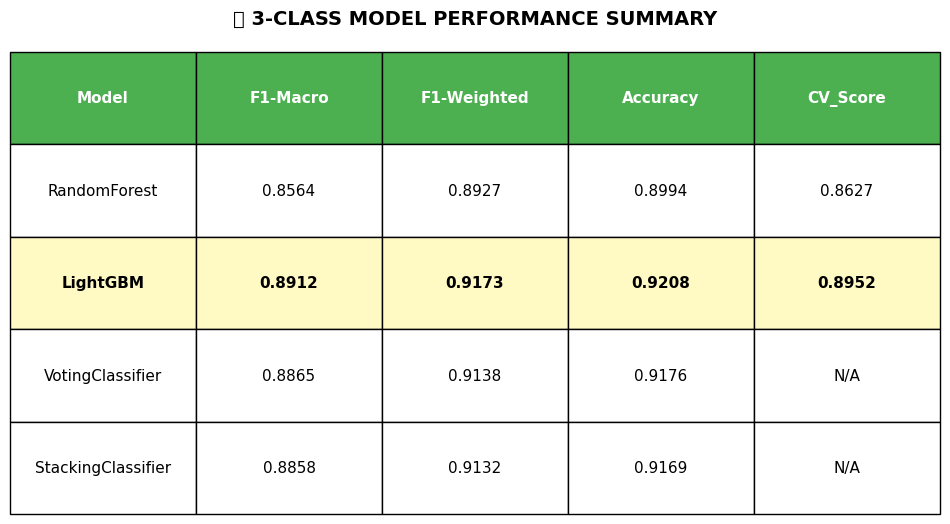


📋 5. CLASS DISTRIBUTION
--------------------------------------------------


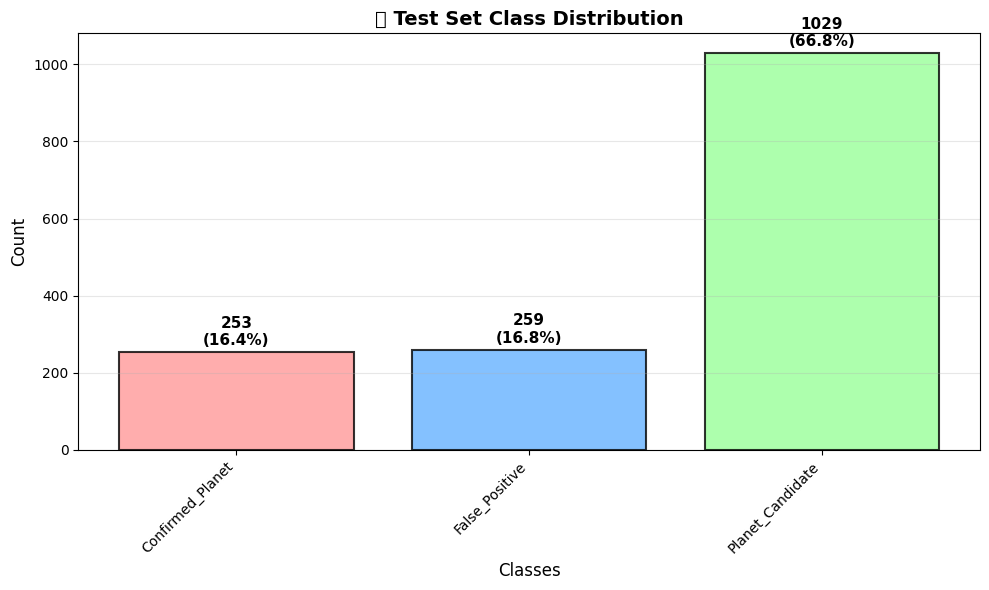


✅ TÜM GRAFİKLER BAŞARIYLA OLUŞTURULDU!


In [9]:
# 7.1 AYRINTI GRAFİKLER - HER BİR GÖRSELİ AYRI AYRI GÖSTER

def create_individual_plots(results_dict, y_true, class_names):
    """
    Her bir grafiği ayrı ayrı oluştur ve göster
    """
    if len(results_dict) == 0:
        print("⚠️ No results available for plotting!")
        return
    
    model_names = list(results_dict.keys())
    
    # 1. F1-Score Karşılaştırması (Ayrı Grafik)
    print("📊 1. F1-SCORE KARŞILAŞTIRMASI")
    print("-" * 50)
    
    plt.figure(figsize=(12, 8))
    f1_macro_scores = [results_dict[name].get('f1_macro', 0) for name in model_names]
    f1_weighted_scores = [results_dict[name].get('f1_weighted', 0) for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, f1_macro_scores, width, label='F1-Macro', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x + width/2, f1_weighted_scores, width, label='F1-Weighted', alpha=0.8, color='lightcoral')
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title('🎯 3-Class F1-Score Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Accuracy Karşılaştırması (Ayrı Grafik)
    print("\n📈 2. ACCURACY KARŞILAŞTIRMASI")
    print("-" * 50)
    
    plt.figure(figsize=(12, 8))
    accuracy_scores = [results_dict[name].get('accuracy', 0) for name in model_names]
    
    bars = plt.bar(model_names, accuracy_scores, alpha=0.8, color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('📊 3-Class Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. En İyi Model için Confusion Matrix (Ayrı Grafik)
    print("\n🎯 3. CONFUSION MATRIX (EN İYİ MODEL)")
    print("-" * 50)
    
    # Find best model by F1-Macro
    best_model_name = max(model_names, key=lambda x: results_dict[x].get('f1_macro', 0))
    best_results = results_dict[best_model_name]
    
    print(f"En iyi model: {best_model_name}")
    print(f"F1-Macro: {best_results.get('f1_macro', 0):.4f}")
    
    if 'y_pred' in best_results:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true, best_results['y_pred'])
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        im = plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
        plt.title(f'🎯 Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
        
        # Add text annotations
        thresh = cm_normalized.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                        ha="center", va="center", fontsize=12, fontweight='bold',
                        color="white" if cm_normalized[i, j] > thresh else "black")
        
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
        plt.yticks(range(len(class_names)), class_names)
        
        # Add colorbar
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
    
    # 4. Performans Metrikleri Tablosu (Ayrı Grafik)
    print("\n🏆 4. PERFORMANS METRİKLERİ TABLOSU")
    print("-" * 50)
    
    # Create detailed metrics table
    metrics_data = []
    for name in model_names:
        metrics_data.append({
            'Model': name,
            'F1-Macro': f"{results_dict[name].get('f1_macro', 0):.4f}",
            'F1-Weighted': f"{results_dict[name].get('f1_weighted', 0):.4f}",
            'Accuracy': f"{results_dict[name].get('accuracy', 0):.4f}",
            'CV_Score': f"{results_dict[name].get('cv_score', 0):.4f}" if 'cv_score' in results_dict[name] else "N/A"
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create table plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                    cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    # Color header
    for i in range(len(metrics_df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color best model row
    best_idx = metrics_df[metrics_df['Model'] == best_model_name].index[0] + 1
    for i in range(len(metrics_df.columns)):
        table[(best_idx, i)].set_facecolor('#FFF9C4')
        table[(best_idx, i)].set_text_props(weight='bold')
    
    plt.title('🏆 3-CLASS MODEL PERFORMANCE SUMMARY', fontsize=14, fontweight='bold', pad=20)
    plt.show()
    
    # 5. Class Distribution (Bonus)
    print("\n📋 5. CLASS DISTRIBUTION")
    print("-" * 50)
    
    plt.figure(figsize=(10, 6))
    class_counts = pd.Series(y_true).value_counts().sort_index()
    
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    bars = plt.bar(range(len(class_names)), class_counts.values, 
                   color=colors[:len(class_names)], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('📊 Test Set Class Distribution', fontsize=14, fontweight='bold')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels and percentages
    total = sum(class_counts.values)
    for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
        height = bar.get_height()
        percentage = (count / total) * 100
        plt.annotate(f'{count}\n({percentage:.1f}%)', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Ayrı grafikleri çalıştır
if 'all_results' in locals() and len(all_results) > 0:
    print("🎨 TÜM GRAFİKLERİ AYRI AYRI OLUŞTURULUYOR...")
    print("=" * 60)
    
    # Get class names from mapping
    if 'class_mapping' in locals():
        class_names = class_mapping['class_names']
    else:
        class_names = ['Confirmed_Planet', 'False_Positive', 'Planet_Candidate']
    
    create_individual_plots(all_results, y_test, class_names)
    
    print("\n✅ TÜM GRAFİKLER BAŞARIYLA OLUŞTURULDU!")
    
else:
    print("⚠️ Önce modelleri eğitin!")